In [ ]:
# !pip install tensorflow_datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [ ]:
# load dataset from tdfs
dataset, info = tfds.load('horses_or_humans', with_info=True, as_supervised=True)

In [ ]:
dataset

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [ ]:
info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir='/root/tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [ ]:
info.supervised_keys, info.features['label'].names

(('image', 'label'), ['horses', 'humans'])

In [ ]:
class_names = info.features['label'].names
class_names

['horses', 'humans']

In [ ]:
# save dataset to local directory
for i, example in enumerate(dataset['train']):
  image, label = example
  save_dir = 'horses_or_humans/train/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)
  filepath = save_dir + "/" + class_names[label] + "_" + str(i) + ".jpg"
  tf.keras.preprocessing.image.save_img(filepath, image.numpy())

In [ ]:
for i, example in enumerate(dataset['test']):
  image, label = example
  save_dir = 'horses_or_humans/test/{}'.format(class_names[label])
  os.makedirs(save_dir, exist_ok=True)
  filepath = save_dir + "/" + class_names[label] + "_" + str(i) + ".jpg"
  tf.keras.preprocessing.image.save_img(filepath, image.numpy())

In [ ]:
# use of image image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (300, 300)
batch_size = 32

train_dir = 'horses_or_humans/train'
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary')

Found 1027 images belonging to 2 classes.


In [ ]:
train_generator.class_indices, train_generator.class_mode, train_generator.filenames[:5]

({'horses': 0, 'humans': 1},
 'binary',
 ['horses/horses_0.jpg',
  'horses/horses_1.jpg',
  'horses/horses_1000.jpg',
  'horses/horses_1004.jpg',
  'horses/horses_1005.jpg'])

In [ ]:
test_dir = 'horses_or_humans/test'
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode='binary')

Found 256 images belonging to 2 classes.


## Data Visualization (Display sample data in subplots matrix)

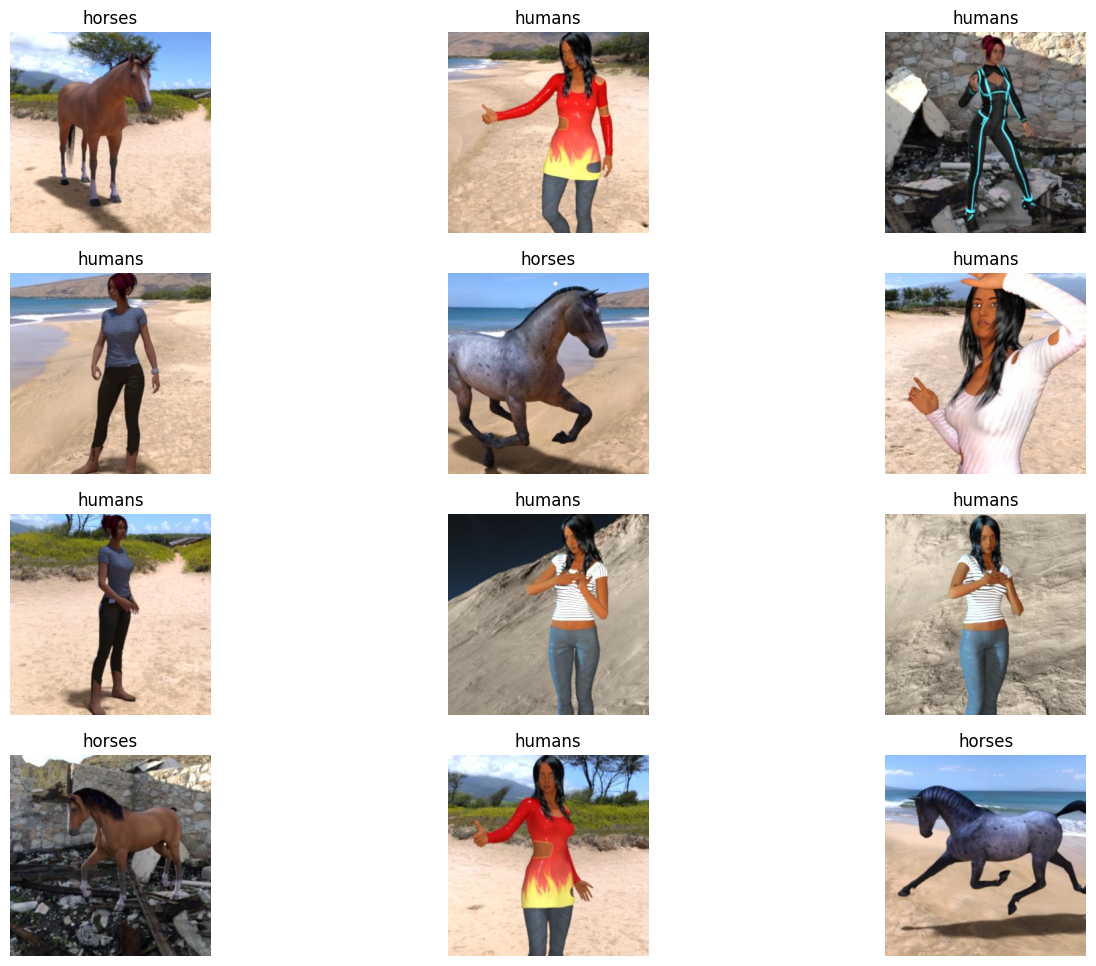

In [ ]:
import matplotlib.pyplot as plt

nrows = 4
ncols = 3

fig = plt.gcf()
fig.set_size_inches(nrows*4, ncols*4)

next_batch = train_generator.next()
for i in range(0, ncols*nrows):
  ax=plt.subplot(nrows, ncols, i + 1)
  ax.axis('Off')
  plt.imshow(next_batch[0][i])
  class_idx=next_batch[1][i]
  plt.title(class_names[int(class_idx)])
plt.show()

## Building CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def get_model():
  model = Sequential()
  # 1st CNN layer
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(300,300,3)))
  model.add(MaxPooling2D(pool_size=(5,5)))
  # 2nd CNN layer
  model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(5,5)))
  # 3rd CNN layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=2))
  # 4th CNN layer
  model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
  # Flatten CNN layer
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  # output layer
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 298, 298, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 128)       0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 57, 57, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 512)         1180160   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 512)        

In [ ]:
model.layers[0].get_weights()     #randomly generated weights for layer 1
# MaxPool and Flatten has no weights
model.layers[1].get_weights(), model.layers[5].get_weights()

([], [])

## Model Training

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=4, validation_data=test_generator)

Epoch 1/4
33/33 [==============================] - 19s 185ms/step - loss: 0.6279 - accuracy: 0.6173 - val_loss: 0.8366 - val_accuracy: 0.8281
Epoch 2/4
33/33 [==============================] - 6s 176ms/step - loss: 0.2082 - accuracy: 0.9309 - val_loss: 0.5375 - val_accuracy: 0.8594
Epoch 3/4
33/33 [==============================] - 6s 177ms/step - loss: 0.1192 - accuracy: 0.9611 - val_loss: 1.7642 - val_accuracy: 0.8086
Epoch 4/4
33/33 [==============================] - 6s 164ms/step - loss: 0.0359 - accuracy: 0.9883 - val_loss: 2.9707 - val_accuracy: 0.7812


In [ ]:
# the model is overfitting

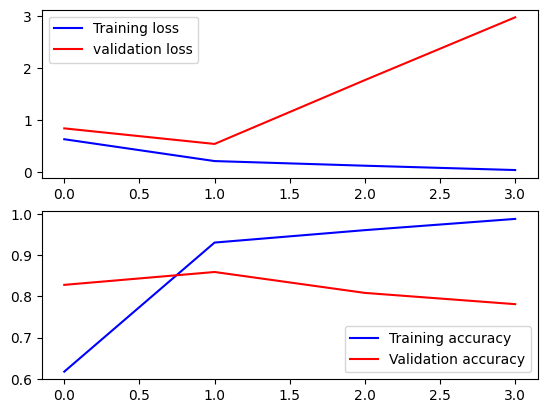

In [ ]:
# plot training history
fig,ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='validation loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()

### Observation after epochs and plotting
1. very high training accuracy (overfitting)
2. Validation accuracy fell below training accuracy (overfitting)
3. Gap between training and accuracy accuracy

## Model Save and Load

In [ ]:
from tensorflow.keras.models import load_model
# save model
model.save('horses_or_humans.h5')
# load model
model_load = ('horses_or_humans.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Image Class Prediction

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [ ]:
# load image
model_load= load_model('horses_or_humans.h5')
# read sample image on test data: will use any human data. copied the file path from the test data
img = image.load_img('/content/horses_or_humans/test/horses/horses_1.jpg', target_size=(300,300))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255

prediction = model_load(img)
print(prediction)

TH = 0.5
predicted_class = int(prediction[0][0]>TH)
print(predicted_class)

tf.Tensor([[0.00015565]], shape=(1, 1), dtype=float32)
0


In [ ]:
# class mapping
class_indices = train_generator.class_indices
labels = {v:k for k,v in class_indices.items()}
labels[predicted_class]
print('The image is a ', labels[predicted_class])

The image is a  horses
